**Imports**

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Dataset**

In [2]:
image_path = []
labels = []

for i in os.listdir(r'V:\Sem_4_notes\Pytorch\afhq'):
  #print(i)
  for label in os.listdir(fr'V:\Sem_4_notes\Pytorch\afhq\{i}'):
    #print(label)
    for image in os.listdir(fr'V:\Sem_4_notes\Pytorch\afhq\{i}\{label}'):
      #print(image)
      image_path.append(fr'V:\Sem_4_notes\Pytorch\afhq\{i}\{label}\{image}')
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_path','labels'])
print(data_df['labels'].unique())
data_df.head()

['cat' 'dog' 'wild']


,image_path,labels
0,V:\Sem_4_notes\Pytorch\afhq\train\cat\flickr_c...,cat
1,V:\Sem_4_notes\Pytorch\afhq\train\cat\flickr_c...,cat
2,V:\Sem_4_notes\Pytorch\afhq\train\cat\flickr_c...,cat
3,V:\Sem_4_notes\Pytorch\afhq\train\cat\flickr_c...,cat
4,V:\Sem_4_notes\Pytorch\afhq\train\cat\flickr_c...,cat


**Splitting Dataset**

In [3]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


**Transforms & LabelEncoder**

In [4]:
label_encoder = LabelEncoder()

label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize(mean=[0.5], std=[0.5])
])

**Dataset Object**

In [5]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image,label

**train,test & val datasets**

In [6]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)

**Visualising Images**

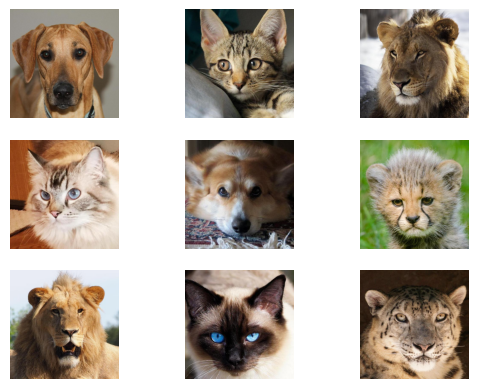

In [7]:
train_dataset.__getitem__(2)

#VISUALIZING IMAGES

n_rows = 3
n_cols =  3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

**HyperParameters**

In [8]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10


**DataLoaders**

In [9]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE,shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE,shuffle = True)

**Network Class**

In [10]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size= 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten() 
    self.linear = nn.Linear((128*16*16), 128)

    self.output  = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x) # -> (32,128,128)
    x = self.pooling(x) # -> (64, 32, 32)
    x = self.relu(x)

    x = self.conv2(x) # -> (64, 64, 64)
    x = self.pooling(x) # -> (64, 32, 32)
    x = self.relu(x)

    x = self.conv3(x) # -> (128, 32, 32)
    x = self.pooling(x) # -> (128, 16, 16)
    x = self.relu(x) 

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)
    return x


**Model Creation**

In [11]:
model = Net().to(device)
print(device)

cuda


**Model Summary**

In [12]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

**Loss function and Optimizer**

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

**Training**

In [14]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_loss_train = 0
  total_acc_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    labels = labels.to(device).long()
    optimizer.zero_grad()

    outputs = model(inputs)

    train_loss = loss_fn(outputs, labels)
    total_loss_train+= train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    
    optimizer.step()
    #print(torch.argmax(outputs, axis = 1) == labels)
    #print((torch.argmax(outputs, axis = 1) == labels).sum().item())

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device).long()
      
      outputs = model(inputs)
      val_loss = loss_fn(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) ==labels).sum().item()
      total_acc_val += val_acc

  #calculating average loss and accuracy
  avg_train_loss = round(total_loss_train/len(train_loader), 4)
  avg_val_loss = round(total_loss_val/len(val_loader), 4)

  avg_train_acc = round((total_acc_train/train_dataset.__len__())* 100, 4)
  avg_val_acc = round((total_acc_val/val_dataset.__len__())*100, 4)

  # Appending to plots
  total_loss_train_plot.append(avg_train_loss)
  total_loss_validation_plot.append(avg_val_loss)
  total_acc_train_plot.append(avg_train_acc)
  total_acc_validation_plot.append(avg_val_acc)
  

  print(f'''Epoch{epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss} | Train Accuracy: {avg_train_acc}% |
            validation Loss: {avg_val_loss} | Validation Accuracy: {avg_val_acc}%
            ''')

Epoch1/10, Train Loss: 0.4248 | Train Accuracy: 83.013% |
            validation Loss: 0.247 | Validation Accuracy: 91.1157%
            
Epoch2/10, Train Loss: 0.1798 | Train Accuracy: 93.5524% |
            validation Loss: 0.1859 | Validation Accuracy: 93.1405%
            
Epoch3/10, Train Loss: 0.1171 | Train Accuracy: 95.9791% |
            validation Loss: 0.1865 | Validation Accuracy: 93.5124%
            
Epoch4/10, Train Loss: 0.0863 | Train Accuracy: 96.9445% |
            validation Loss: 0.1117 | Validation Accuracy: 96.1157%
            
Epoch5/10, Train Loss: 0.0702 | Train Accuracy: 97.5556% |
            validation Loss: 0.0952 | Validation Accuracy: 96.8182%
            
Epoch6/10, Train Loss: 0.0572 | Train Accuracy: 98.0073% |
            validation Loss: 0.0966 | Validation Accuracy: 96.4876%
            
Epoch7/10, Train Loss: 0.0469 | Train Accuracy: 98.4058% |
            validation Loss: 0.101 | Validation Accuracy: 96.7769%
            
Epoch8/10, Train Loss: 

**Testing**

In [15]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device).long()
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = loss_fn(predictions, labels)
    total_loss_test += test_loss.item()

  print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())* 100, 4)}% | Loss : {round((total_loss_test/len(train_loader))*100, 4)}")

Accuracy Score is: 97.5196% | Loss : 1.7766


**Saving Parameters**

In [16]:
torch.save(model.state_dict(),'Image_classifier_parameters.pth')

**Load**


In [17]:
model = Net() # creating an instance of model

model.load_state_dict(torch.load('Image_classifier_parameters.pth'))
model.eval()

C:\Users\ROG\AppData\Local\Temp\ipykernel_10412\492099143.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Image_classifier_parameters.p

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

**Inference**

In [25]:
image_path = r'V:\Sem_4_notes\Pytorch\cat_2.jpeg'

image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.ToTensor(),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize(mean=[0.5], std=[0.5])
])

image = transform(image).unsqueeze(0) 

# sending to device
image = image.to(device)
model = model.to(device)

with torch.no_grad():
  output = model(image)
  predicted_class = torch.argmax(output,dim = 1).item()

print(f'Predicted class : {predicted_class}')
print(label_encoder.inverse_transform([predicted_class]))

Predicted class : 1
['dog']
